In [1]:
import requests
import re
import json
from bs4 import BeautifulSoup as bs
from pprint import pprint
from time import sleep
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36'}

client = MongoClient('127.0.0.1', 27017)
db = client['db_of_vacancies']
job_data = db.job_data
duplicate_vacancies = db.duplicate_vacancies

# 1. Развернуть у себя на компьютере/виртуальной машине/хостинге MongoDB и реализовать функцию, которая будет добавлять только новые вакансии/продукты в вашу базу.

Взял за основу дз-3, разделил функцию по сбору вакансий с hh.ru, superjob.ru и rabota.ru на три отдельных функции, каждая из которых добавляет информацию о вакансиях в БД "db_of_vacancies" в JSON-формате. 

Плюсом полностью переписал функцию по обработке строки с зп, теперь она обрабатывает строчки с одной, двумя, тремя, четыремя блоками цифр, разделяет цифры зп по разделителям "до", "/", "—", "-", убирает спецсимволы, обрабатывает всякие "по договорённости", "на руки" и вообще ничего такая получилась)

Поле '_id' в БД - это ссылка на страницу вакансии, за счёт чего достигается проверка на уникальность добавляемых данных. А все дубли отправляются в отдельную коллекцию и в финальном сообщении мы видим:
- сколько вакансий обработано
- сколько из них добавилось в БД
- и сколько было обработано дублей

In [3]:
# db.drop_collection('job_data')
# db.drop_collection('duplicate_vacancies')

## обработка строки с зарплатой

In [4]:
def restructuring_srt(vacancy_salary):
    """ здесь обрабатываем строчку с зарплатой, превращая цифры в int, а валюту в str """
    minimal_salary, maximal_salary, currency_name_letter, additional_verification = None, None, [], []
    if vacancy_salary: 
        string_salary = vacancy_salary.text.replace('\xa0', ' ') 
        for letter in string_salary[::-1]: 
            if letter.isdigit(): 
                additional_verification.append(letter) 
                break 
            currency_name_letter.append(letter) 
        if additional_verification: 
            currency_name = ''.join(currency_name_letter[::-1]).replace('\xa0', '').strip()
            if len(currency_name) > 5: 
                if ' ' in currency_name: 
                    currency_name = currency_name[0:currency_name.index(' ')] 
                elif '/' in currency_name: 
                    currency_name = currency_name[0:currency_name.index('/')] 
        else:
            currency_name = None       
        min_split_salary, max_split_salary = '', '' 
        for i in string_salary.split(' '): 
            if i != 'до' and i != '–' and i !='-' and i != '—': 
                min_split_salary = ''.join(re.findall('(\d+)', string_salary)) 
                if min_split_salary:
                    minimal_salary = int(min_split_salary) 
            else:
                min_split_salary = string_salary[:string_salary.index(i)]
                if min_split_salary:
                    minimal_salary = int(''.join(re.findall('(\d+)', min_split_salary)))
                max_split_salary = string_salary[string_salary.index(i):]
                if max_split_salary:
                    maximal_salary = int(''.join(re.findall('(\d+)', max_split_salary)))
                break
        return minimal_salary, maximal_salary, currency_name
    currency_name = None
    return minimal_salary, maximal_salary, currency_name

## функция, что собирает БД

In [5]:
def collect_data(num, name, link, minimal_salary, maximal_salary, currency_name, site_name):
    json = {}
    duplicate = {}
    success, failure = 0, 0
    json = {'_id': link,
        'название': name,
        'ссылка': link,
        'зарплата от': minimal_salary,
        'зарплата до': maximal_salary,
        'валюта': currency_name,
        'сайт': site_name} 
    try:
        job_data.insert_one(json)
        success = 1
    except DuplicateKeyError:
        duplicate = {
            'название': name,
            'ссылка': link}
        duplicate_vacancies.insert_one(duplicate)
        print(f'Дубль! вакансия "{name}" уже есть в базе')
        failure = 1
    return json, success, failure

## HeadHunter.ru

In [6]:
def HH(headers, page):
    s, f = 0, 0
    params = {'page': page, 'hhtmFrom': 'vacancy_search_catalog'}
    job_search = 'prodavets-konsultant'
    site_name = 'https://hh.ru/vacancies/'
    url = f'{site_name}{job_search}'    
    session = requests.Session()
    response = session.get(url, headers=headers, params=params)   
    start_node, json_vacancies, num = [headers], {}, 0
    while len(start_node) > 0: 
        if params['page'] % 10 == 0:
            print(f"Обработка страницы {params['page']}")
        dom = bs(response.text, 'html.parser')
        start_node = dom.find_all('div', {'class': ['vacancy-serp-item-body__main-info']})
        for vacancy in start_node:
            num += 1
            vacansy_text_and_link = vacancy.find('a', {'data-qa': 'vacancy-serp__vacancy-title'})
            vacancy_salary = vacancy.find('span', {'data-qa': 'vacancy-serp__vacancy-compensation'})
            adding_a_path = 'h'    
            minimal_salary, maximal_salary, currency_name = restructuring_srt(vacancy_salary)    
            name = vacansy_text_and_link.text.replace('\n', '').strip()
            link = adding_a_path + vacansy_text_and_link['href'][1:]
            json_vacancies[num], success, failure = collect_data(num, name, link, minimal_salary, maximal_salary, currency_name, site_name[:-10])
            s += success
            f += failure
        params['page'] += 1
        response = session.get(url, headers=headers, params=params)
        sleep(2)   
    print('*******' * 10)
    print(f'{site_name[:-10]}\nобработано {num} вакансий\nуспешно добавлено в коллекцию job_data: {s}')
    if f:
        print(f'дублей: {f} шт., они отправлены в duplicate_vacancies\n')
    return json_vacancies

## Superjob.ru

In [7]:
def SJ(headers, page):
    s, f = 0, 0
    params = {'page': page}
    job_search = 'prodavec-konsultant.html'
    site_name = 'https://www.superjob.ru/'
    url = f'{site_name}vakansii/{job_search}'
    session = requests.Session()
    response = session.get(url, headers=headers, params=params)
    start_node, json_vacancies, num = [headers], {}, 0   
    while len(start_node) > 0:
        print(f"Обработка страницы № {params['page']}")
        dom = bs(response.text, 'html.parser')
        start_node = dom.find_all('div', {'class': '_2lp1U _2J-3z _3B5DQ'})
        for vacancy in start_node:
            num += 1
            vacansy_text_and_link = vacancy.find('a', {'class': 'YrERR'})
            vacancy_salary = vacancy.find('span', {'class': '_2eYAG'})
            minimal_salary, maximal_salary, currency_name = restructuring_srt(vacancy_salary)
            name = vacansy_text_and_link.text.replace('\n', '').strip()
            link = site_name + vacansy_text_and_link['href'][1:]
            json_vacancies[num], success, failure = collect_data(num, name, link, minimal_salary, maximal_salary, currency_name, site_name)
            s += success
            f += failure
        params['page'] += 1
        response = session.get(url, headers=headers, params=params)
        sleep(5) 
    print('*******' * 10)
    print(f'{site_name}\nобработано {num} вакансий\nуспешно добавлено в коллекцию job_data: {s}')
    if f:
        print(f'дублей: {f} шт., они отправлены в duplicate_vacancies\n')
    return json_vacancies

## Rabota.ru

In [8]:
def RR(headers, page):
    s, f = 0, 0
    params = {'sort': 'relevance', 'specialization_ids': '2195', 'page': page}
    job_search = 'vacancy/'
    site_name = 'https://www.rabota.ru/'
    url = f'{site_name}{job_search}' 
    session = requests.Session()
    response = session.get(url, headers=headers, params=params)
    start_node, json_vacancies, num = [headers], {}, 0 
    while len(start_node) > 0:
        if params['page'] % 10 == 0:
            print(f"Обработка страницы {params['page']}")
        dom = bs(response.text, 'html.parser')
        start_node = dom.find_all('header', {'class': 'vacancy-preview-card__header'})
        for vacancy in start_node:
            num += 1
            vacansy_text_and_link = vacancy.find('a', {'class': 'vacancy-preview-card__title_border'})
            vacancy_salary = vacancy.find('div', {'class': 'vacancy-preview-card__salary'}).findChildren(recursive=False)[0]
            minimal_salary, maximal_salary, currency_name = restructuring_srt(vacancy_salary)
            name = vacansy_text_and_link.text.replace('\n', '').strip()
            link = site_name + vacansy_text_and_link['href'][1:]
            json_vacancies[num], success, failure = collect_data(num, name, link, minimal_salary, maximal_salary, currency_name, site_name)
            s += success
            f += failure
        params['page'] += 1
        response = session.get(url, headers=headers, params=params)
        sleep(3) 
    print('*******' * 10)
    print(f'{site_name}\nобработано {num} вакансий\nуспешно добавлено в коллекцию job_data: {s}')
    if f:
        print(f'дублей: {f} шт., они отправлены в duplicate_vacancies\n')
    return json_vacancies

#### проверим за собой

In [9]:
headhunter = HH(headers, 0)

Обработка страницы 0
Обработка страницы 10
Обработка страницы 20
Обработка страницы 30
Обработка страницы 40
**********************************************************************
https://hh.ru/
обработано 2000 вакансий
успешно добавлено в коллекцию job_data: 2000


In [10]:
superjob = SJ(headers, 1)

Обработка страницы № 1
Обработка страницы № 2
Обработка страницы № 3
Обработка страницы № 4
Обработка страницы № 5
Обработка страницы № 6
Обработка страницы № 7
**********************************************************************
https://www.superjob.ru/
обработано 233 вакансий
успешно добавлено в коллекцию job_data: 233


In [11]:
rabota = RR(headers, 1)

Обработка страницы 10
Дубль! вакансия "Продавец - консультант (м. Бунинская аллея)" уже есть в базе
Обработка страницы 20
Обработка страницы 30
Дубль! вакансия "Продавец одежды и белья (м. Академическая)" уже есть в базе
Обработка страницы 40
Дубль! вакансия "Продавец-консультант" уже есть в базе
**********************************************************************
https://www.rabota.ru/
обработано 918 вакансий
успешно добавлено в коллекцию job_data: 915
дублей: 3 шт., они отправлены в duplicate_vacancies



#### попробуем добавить дублей с hh.ru с 39-й страницы - не добавятся

In [12]:
test = HH(headers, 39)

Дубль! вакансия "Продавец-консультант, ТЦ Свиблово" уже есть в базе
Дубль! вакансия "Продавец-консультант (м. Славянский бульвар)" уже есть в базе
Дубль! вакансия "Продавец-консультант (м.Лефортово,м. Электрозаводская)" уже есть в базе
Дубль! вакансия "Продавец-консультант (ТЦ Л153 м. Братиславская)" уже есть в базе
Дубль! вакансия "Продавец-консультант (ВЕГАС СИТИ, м. Мякинино)" уже есть в базе
Дубль! вакансия "Продавец-консультант Tezenis (Москва)" уже есть в базе
Дубль! вакансия "Продавец-консультант ( м. Новые Черемушки)" уже есть в базе
Дубль! вакансия "Продавец-консультант в фирменный салон Samsung" уже есть в базе
Дубль! вакансия "Продавец-консультант ECCO (ТЦ Океания)" уже есть в базе
Дубль! вакансия "Продавец-консультант (ст.м. Юго-Западная, ТЦ Авеню)" уже есть в базе
Дубль! вакансия "Продавец - консультант (м. Шаболовская)" уже есть в базе
Дубль! вакансия "Продавец-консультант (м. Сходненская)" уже есть в базе
Дубль! вакансия "Продавец-консультант (м.Митино)" уже есть в базе


# 2. * Написать функцию, которая производит поиск и выводит на экран вакансии с заработной платой больше введённой суммы (необходимо анализировать оба поля зарплаты).

Функция job_search_by_salary принимает два аргумента - сумму зарплаты "от" и сумма зарплаты "до" и возвращает список вакансий с зп выше переданных аргументов и общее количество таких вакансий. Для примера обращаюсь к функции дважды с разными аргументами

In [13]:
def job_search_by_salary(salary_min, salary_max):
    count = 0 
    for i in job_data.find({'зарплата от': {'$gt': salary_min}, 'зарплата до': {'$gt': salary_max}}):
        pprint(i)
        print('')
        count += 1
    return f'найдено {count} подходящих вакансий'

In [14]:
job_search_by_salary(100000, 200000)

{'_id': 'https://hh.ru/vacancy/69252218?query=%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B2%D0%B5%D1%86-%D0%BA%D0%BE%D0%BD%D1%81%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D0%BD%D1%82',
 'валюта': 'руб.',
 'зарплата до': 220000,
 'зарплата от': 120000,
 'название': 'Продавец-консультант',
 'сайт': 'https://hh.ru/',
 'ссылка': 'https://hh.ru/vacancy/69252218?query=%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B2%D0%B5%D1%86-%D0%BA%D0%BE%D0%BD%D1%81%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D0%BD%D1%82'}

{'_id': 'https://hh.ru/vacancy/68789202?query=%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B2%D0%B5%D1%86-%D0%BA%D0%BE%D0%BD%D1%81%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D0%BD%D1%82',
 'валюта': 'руб.',
 'зарплата до': 500000,
 'зарплата от': 200000,
 'название': 'Продавец-консультант "РИГАМОЛЛ"',
 'сайт': 'https://hh.ru/',
 'ссылка': 'https://hh.ru/vacancy/68789202?query=%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B2%D0%B5%D1%86-%D0%BA%D0%BE%D0%BD%D1%81%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D0%BD%D1%82'}

{'_id': 'https://hh.ru/vacancy/69678841?query=%D0%BF%D1%80%D0%B

'найдено 3 подходящих вакансий'

In [15]:
# поубавим аппетиты по зп

job_search_by_salary(80000, 190000)

{'_id': 'https://hh.ru/vacancy/69252218?query=%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B2%D0%B5%D1%86-%D0%BA%D0%BE%D0%BD%D1%81%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D0%BD%D1%82',
 'валюта': 'руб.',
 'зарплата до': 220000,
 'зарплата от': 120000,
 'название': 'Продавец-консультант',
 'сайт': 'https://hh.ru/',
 'ссылка': 'https://hh.ru/vacancy/69252218?query=%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B2%D0%B5%D1%86-%D0%BA%D0%BE%D0%BD%D1%81%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D0%BD%D1%82'}

{'_id': 'https://hh.ru/vacancy/54550982?query=%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B2%D0%B5%D1%86-%D0%BA%D0%BE%D0%BD%D1%81%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D0%BD%D1%82',
 'валюта': 'руб.',
 'зарплата до': 200000,
 'зарплата от': 100000,
 'название': 'Продавец-консультант в магазин одежды',
 'сайт': 'https://hh.ru/',
 'ссылка': 'https://hh.ru/vacancy/54550982?query=%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B2%D0%B5%D1%86-%D0%BA%D0%BE%D0%BD%D1%81%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D0%BD%D1%82'}

{'_id': 'https://hh.ru/vacancy/68789202?query=%D0%BF%D1%8

'найдено 9 подходящих вакансий'

# 3. * Любая аналитика. Например matching ваканский с разных площадок

Функция statistics_on_vacancies_and_salaries выводит статистику по сайтам

In [16]:
def statistics_on_vacancies_and_salaries(website):
    count = 0
    for i in job_data.find({'сайт': website}):
        count += 1
    print(f'статистика по сайту {website}')
    print(f'всего вакансий {count}')
    jobs_without_salary = 0
    for i in job_data.find({'сайт': website, 'зарплата от': None, 'зарплата до': None}):
        jobs_without_salary += 1
    print(f'без указания зп {jobs_without_salary}')
    vacancies_without_ceiling = 0
    for i in job_data.find({'сайт': website, 'зарплата от': {'$gt': 0}, 'зарплата до': None}):
        vacancies_without_ceiling += 1
    print(f'без потолка по зп {vacancies_without_ceiling}')
    total, meaning_min, meaning_min_sum, meaning_max = 0, float('inf'), 0, float('-inf')
    for i in job_data.find({'сайт': website, '$or': [{'зарплата от': {'$gt': 0}}, {'зарплата до': {'$gt': 0}}]}):
        if i['зарплата от']:
            meaning_min_sum += i['зарплата от']
            if meaning_min > i['зарплата от']:
                meaning_min = i['зарплата от']
        if i['зарплата до']:
            if i['зарплата до'] > meaning_max:
                meaning_max = i['зарплата до']
        total += 1
    mean = round(meaning_min_sum/total, 2)
    print(f'минимальная указанная зарплата: {meaning_min}\nв среднем зп начинаются от {mean}')
    print(f'максимальная указанная зарплата: {meaning_max}')
    return count, jobs_without_salary, vacancies_without_ceiling, meaning_min, meaning_max, mean

In [17]:
count, jobs_without_salary, vacancies_without_ceiling, meaning_min, meaning_max, mean = statistics_on_vacancies_and_salaries('https://www.rabota.ru/')
rr = [count, jobs_without_salary, vacancies_without_ceiling, meaning_min, meaning_max, int(mean)]

статистика по сайту https://www.rabota.ru/
всего вакансий 915
без указания зп 16
без потолка по зп 380
минимальная указанная зарплата: 2000
в среднем зп начинаются от 45364.65
максимальная указанная зарплата: 200000


In [18]:
count, jobs_without_salary, vacancies_without_ceiling, meaning_min, meaning_max, mean = statistics_on_vacancies_and_salaries('https://www.superjob.ru/')
sj = [count, jobs_without_salary, vacancies_without_ceiling, meaning_min, meaning_max, int(mean)]

статистика по сайту https://www.superjob.ru/
всего вакансий 233
без указания зп 11
без потолка по зп 134
минимальная указанная зарплата: 2000
в среднем зп начинаются от 48131.76
максимальная указанная зарплата: 250000


In [19]:
count, jobs_without_salary, vacancies_without_ceiling, meaning_min, meaning_max, mean = statistics_on_vacancies_and_salaries('https://hh.ru/')
hh = [count, jobs_without_salary, vacancies_without_ceiling, meaning_min, meaning_max, int(mean)]

статистика по сайту https://hh.ru/
всего вакансий 2000
без указания зп 76
без потолка по зп 872
минимальная указанная зарплата: 1000
в среднем зп начинаются от 53538.03
максимальная указанная зарплата: 500000


### На основе полученных данных построим красивых графиков

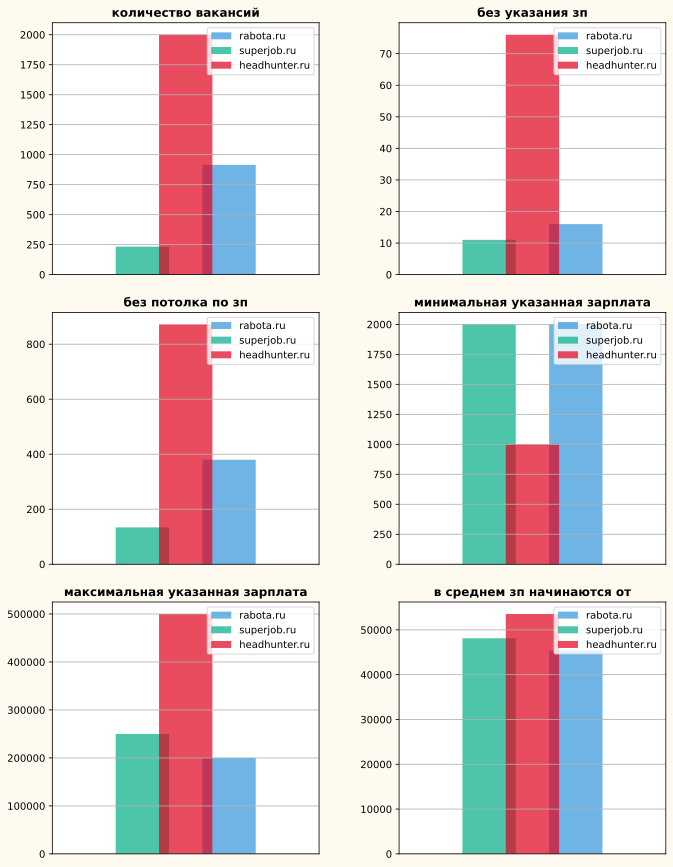

In [20]:
x = np.arange(1, 2)
fig, ax = plt.subplots(nrows=3, ncols=2)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

ax1.bar(x+0.65, rr[0], alpha=0.7, label='rabota.ru', color='#3196dc')
ax1.bar(x-0.65, sj[0], alpha=0.7, label='superjob.ru', color='#00ad88')
ax1.bar(x, hh[0], alpha=0.7, label='headhunter.ru', color='#e1011c')
ax1.set_xlim([-1, 3])
ax1.set_xticks([])
ax1.set_title('количество вакансий', fontweight='bold')
ax1.grid()
ax1.legend()

ax2.bar(x+0.65, rr[1], alpha=0.7, label='rabota.ru', color='#3196dc')
ax2.bar(x-0.65, sj[1], alpha=0.7, label='superjob.ru', color='#00ad88')
ax2.bar(x, hh[1], alpha=0.7, label='headhunter.ru', color='#e1011c')
ax2.set_xlim([-1, 3])
ax2.set_xticks([])
ax2.set_title('без указания зп', fontweight='bold')
ax2.grid()
ax2.legend()

ax3.bar(x+0.65, rr[2], alpha=0.7, label='rabota.ru', color='#3196dc')
ax3.bar(x-0.65, sj[2], alpha=0.7, label='superjob.ru', color='#00ad88')
ax3.bar(x, hh[2], alpha=0.7, label='headhunter.ru', color='#e1011c')
ax3.set_xlim([-1, 3])
ax3.set_xticks([])
ax3.set_title('без потолка по зп', fontweight='bold')
ax3.grid()
ax3.legend()

ax4.bar(x+0.65, rr[3], alpha=0.7, label='rabota.ru', color='#3196dc')
ax4.bar(x-0.65, sj[3], alpha=0.7, label='superjob.ru', color='#00ad88')
ax4.bar(x, hh[3], alpha=0.7, label='headhunter.ru', color='#e1011c')
ax4.set_xlim([-1, 3])
ax4.set_xticks([])
ax4.set_title('минимальная указанная зарплата', fontweight='bold')
ax4.grid()
ax4.legend()

ax5.bar(x+0.65, rr[4], alpha=0.7, label='rabota.ru', color='#3196dc')
ax5.bar(x-0.65, sj[4], alpha=0.7, label='superjob.ru', color='#00ad88')
ax5.bar(x, hh[4], alpha=0.7, label='headhunter.ru', color='#e1011c')
ax5.set_xlim([-1, 3])
ax5.set_xticks([])
ax5.set_title('максимальная указанная зарплата', fontweight='bold')
ax5.grid()
ax5.legend()

ax6.bar(x+0.65, rr[5], alpha=0.7, label='rabota.ru', color='#3196dc')
ax6.bar(x-0.65, sj[5], alpha=0.7, label='superjob.ru', color='#00ad88')
ax6.bar(x, hh[5], alpha=0.7, label='headhunter.ru', color='#e1011c')
ax6.set_xlim([-1, 3])
ax6.set_xticks([])
ax6.set_title('в среднем зп начинаются от', fontweight='bold')
ax6.grid()
ax6.legend()

plt.subplots_adjust(hspace=0.15, wspace=0.3)
fig.set_figwidth(11)    #  ширина Figure
fig.set_figheight(15)    #  высота Figure
fig.set_facecolor('floralwhite')
plt.show()